# Train without normalize

This notebook will use the CHARM view (unbalanced_view_train_test-v1) and will:

1. Apply DFT over dataset windows
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
3. Plot UMAP and T-SNE

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import ExtraSensoryBalancedResampledView20HZ, UCIHARUnbalancedView, WISDMInterpolatedUnbalancedView, CHARMUnbalancedView

from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.transforms. stats import StatsTransform
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-09-30 16:09:32.225532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-30 16:09:32.225562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datasets to train the manifold

## Load ExtraSensory

In [3]:
# Load ExtraSensory, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = ExtraSensoryBalancedResampledView20HZ("../../../data/views/ExtraSensory/balanced_view_resampled_20hz", download=False)
train_val_es, test_es = loader.load(concat_train_validation=True)
# X_ es = train_val_es.data.iloc
# X_es = train_val_es.data.iloc[:,1:-6]


train_val_es.data.iloc[:,1:-6]

,accelerometer-x-0,accelerometer-x-1,accelerometer-x-2,accelerometer-x-3,accelerometer-x-4,accelerometer-x-5,accelerometer-x-6,accelerometer-x-7,accelerometer-x-8,accelerometer-x-9,...,gyroscope-z-50,gyroscope-z-51,gyroscope-z-52,gyroscope-z-53,gyroscope-z-54,gyroscope-z-55,gyroscope-z-56,gyroscope-z-57,gyroscope-z-58,gyroscope-z-59
0,-0.724789,-0.507973,0.107924,-0.052122,-0.308210,-0.327109,-0.144647,-0.061857,-0.075849,-0.108986,...,-0.029486,0.011534,-0.032998,0.016543,-0.041989,0.027790,-0.045943,0.052013,-0.077395,0.111475
1,-0.013220,-0.019134,-0.002889,-0.008703,0.013098,0.018542,0.009620,0.016564,0.006461,0.004548,...,0.000029,0.004917,-0.018431,0.004122,0.019265,0.014980,0.022228,0.023919,0.028533,0.013692
2,-0.214355,-0.206973,-0.219664,-0.225939,-0.219012,-0.208570,-0.195748,-0.212864,-0.227196,-0.245031,...,0.002744,0.005068,0.010737,0.009596,0.007746,0.004763,0.013354,0.005289,0.002381,0.008331
3,0.761069,0.757731,0.752873,0.753823,0.753913,0.756301,0.758194,0.756618,0.756947,0.756485,...,0.001041,-0.000783,-0.002598,0.001302,0.000400,0.000531,-0.002842,0.000469,0.000963,-0.001895
4,-0.001454,-0.008433,-0.004865,-0.006524,-0.005949,-0.006001,-0.007217,-0.008985,-0.007185,-0.003809,...,-0.001976,-0.000086,-0.000245,0.001119,-0.001033,0.001574,-0.001405,-0.000204,-0.003032,0.002380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.318814,0.820496,0.829511,1.464799,1.194766,1.340308,0.655106,0.642922,1.672151,1.631894,...,-0.071705,0.560008,0.477855,0.188169,0.514792,-0.305859,-0.512085,-0.384287,-0.300596,-0.197638
140,-3.755993,-2.862513,-2.130942,1.607675,3.116307,2.871448,1.015326,3.089434,5.513042,4.221506,...,-1.275709,-2.031439,-3.953223,-4.451037,-2.519823,-1.071030,-2.209544,-2.579949,-0.775481,0.184701
141,-0.046923,-0.052641,-0.047726,-0.048309,-0.047292,-0.043157,-0.039521,-0.041308,-0.040168,-0.044390,...,-0.006601,-0.004064,0.002956,0.005797,0.001869,-0.003331,0.004593,-0.004651,0.003989,-0.001190
142,-6.725034,-4.565210,-6.688427,-8.245128,-2.401993,6.173494,6.665963,7.925987,2.102236,-0.814744,...,7.413526,2.151802,-1.035741,0.370291,-0.468816,-1.549655,-2.854839,-5.031104,-7.418414,-6.967641


In [4]:
extrasensory_X = np.array(train_val_es.data.iloc[:,1:-6])
extrasensory_Y = np.array(train_val_es.data['activity code'])
tam = len(extrasensory_Y)
extrasensory_id_dataset = np.array(['E']*tam)

## Load UCI-HAR

In [5]:
# Load UCI-HAR, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = UCIHARUnbalancedView("../../../data/views/UCI-HAR/unbalanced_view_train_test-v1", download=False)
train_val_uci, test_uci = loader.load(concat_train_validation=True)

train_val_uci.data['activity code'] = train_val_uci.data['activity code'].astype('int')

In [6]:
# Resampling the dataset to 20 Hz
resampler = SimpleResampler(new_sample_size=60)
transformer = TransformMultiModalDataset(
    transforms=[resampler], new_window_name_prefix="resampled."
)
train_val_uci = transformer(train_val_uci)
test_uci = transformer(test_uci)
# train_uci = pd.DataFrame(train_val_uci.X)
uci_X = train_val_uci.X
uci_Y = train_val_uci.y

tam = len(uci_Y)
uci_id_dataset = np.array(['U']*tam)

## Load WISDM

In [7]:
# Load WISDM and create PandasMultiModalDatasets with the correct pre-defined windows
loader = WISDMInterpolatedUnbalancedView("../../../data/views/WISDM/interpolated_unbalanced_view_train_test-v1", download=False)
train_val_wisdm, test_wisdm = loader.load(concat_train_validation=True)

#rename "activity" with "activity code"
train_val_wisdm.data.rename(columns = {'activity':'activity code'}, inplace = True)
#test.data.rename(columns = {'activity':'activity code'}, inplace = True)

train_val_wisdm.data['activity code'] = train_val_wisdm.data['activity code'].astype('int')


In [8]:
wisdm_X = np.array(train_val_wisdm.data.iloc[:,:-2])
wisdm_Y = np.array(train_val_wisdm.data['activity code'])

tam = len(wisdm_Y)
wisdm_id_dataset = np.array(['W']*tam)

## Concatenate datasets

In [9]:
columns = list(train_val_wisdm.data.iloc[:,:-2].columns)
train_val_es.window_names, train_val_uci.window_names, train_val_wisdm.window_names

(['accelerometer-x',
  'accelerometer-y',
  'accelerometer-z',
  'gyroscope-x',
  'gyroscope-y',
  'gyroscope-z'],
 ['resampled.accel-x',
  'resampled.accel-y',
  'resampled.accel-z',
  'resampled.gyro-x',
  'resampled.gyro-y',
  'resampled.gyro-z'],
 ['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'])

In [10]:
train_X = np.concatenate([wisdm_X, uci_X, extrasensory_X])
train_X.shape

(14016, 360)

In [11]:
train_Y = np.concatenate([wisdm_Y, uci_Y, extrasensory_Y])
train_Y.shape

(14016,)

In [12]:
train_id_dataset = np.concatenate([wisdm_id_dataset, uci_id_dataset, extrasensory_id_dataset])

In [13]:
train_universal = pd.DataFrame(train_X, columns=columns)

train_universal['Id Dataset'] = train_id_dataset

# Datasets to evaluate the manifold

## Load KuHar

In [14]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
#dataset_path = Path("../../../../data/views/KuHar/resampled_view_20Hz")
dataset_path = Path("../../../../data/views/KuHar/resampled_view_20Hz")

In [15]:
train_kh, validation_kh, test_kh = PandasDatasetsIO(dataset_path).load()

In [16]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

train_kh = train_kh.query("`normalized activity code` == 0 or `normalized activity code` == 1 or `normalized activity code` == 2 or `normalized activity code` == 3  or `normalized activity code` == 4 or `normalized activity code` == 5")
validation_kh = validation_kh.query("`normalized activity code` == 0 or `normalized activity code` == 1 or `normalized activity code` == 2 or `normalized activity code` == 3  or `normalized activity code` == 4 or `normalized activity code` == 5")
test_kh = test_kh.query("`normalized activity code` == 0 or `normalized activity code` == 1 or `normalized activity code` == 2 or `normalized activity code` == 3  or `normalized activity code` == 4 or `normalized activity code` == 5")

test_kh

# Creating the target dataset

# combined_target_dset_kh = PandasMultiModalDataset(
#     pd.concat([train_kh, validation_kh, test_kh], ignore_index=True),
#     feature_prefixes=features,
#     label_columns="normalized activity code",
#     as_array=True
# )

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.011216,-0.014091,0.023346,-0.046660,0.010339,0.021423,-0.002919,-0.017072,-0.023408,...,15.166,15.164,18.186,18.187,0,300,1,1500,1077,1
1,1,0.004916,0.034297,0.026488,-0.006901,0.029315,0.020227,0.025579,0.015040,0.016612,...,64.002,64.011,66.992,67.001,0,300,1,6000,1057,1
2,2,0.053367,0.035779,-0.016234,0.081826,-0.022036,0.092562,-0.028284,0.043258,0.038537,...,9.011,9.013,12.003,12.014,0,300,1,900,1001,1
3,3,0.023338,0.026330,0.065440,0.015908,0.023099,0.100371,0.023635,-0.011511,-0.006801,...,19.521,19.510,22.511,22.500,0,300,1,1800,1045,1
4,4,-0.043513,0.065625,-0.009443,-0.200732,0.052663,0.080177,-0.031852,-0.029668,-0.093965,...,45.533,45.492,48.577,48.517,0,300,1,4500,1028,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,352,-3.203606,-2.557967,-1.157920,1.950214,0.848038,-0.263877,-0.062942,0.915494,0.950553,...,0.004,0.003,2.957,2.956,16,300,6,0,1045,4
353,353,-6.721575,-0.794461,-5.666369,-2.010574,-0.770171,4.872895,-4.065932,17.244017,9.217380,...,5.930,5.929,8.883,8.882,16,300,6,600,1045,4
354,354,-2.988702,-0.139523,-6.524414,-2.912747,0.114480,0.755789,1.479858,7.367267,7.789468,...,52.048,52.035,55.036,55.025,16,300,1,5100,1044,4
355,355,7.969150,12.008727,-3.349766,0.242767,-2.391437,-2.748834,-5.172150,-6.179622,-5.008845,...,12.008,12.009,14.997,15.008,16,300,1,1200,1036,4


In [17]:
test_kh.iloc[:,1:-10]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,0.011216,-0.014091,0.023346,-0.046660,0.010339,0.021423,-0.002919,-0.017072,-0.023408,0.005562,...,-0.006564,-0.013314,-0.008751,-0.005504,-0.007862,-0.008045,-0.006388,-0.006671,-0.004199,-0.005945
1,0.004916,0.034297,0.026488,-0.006901,0.029315,0.020227,0.025579,0.015040,0.016612,0.027536,...,0.000529,-0.000628,-0.004678,0.001484,-0.001597,0.000462,0.000871,0.000165,0.000288,-0.002365
2,0.053367,0.035779,-0.016234,0.081826,-0.022036,0.092562,-0.028284,0.043258,0.038537,0.013199,...,-0.010379,-0.000136,-0.007605,-0.004541,0.001959,-0.013335,-0.000956,-0.012968,-0.003183,-0.004695
3,0.023338,0.026330,0.065440,0.015908,0.023099,0.100371,0.023635,-0.011511,-0.006801,0.043358,...,-0.010526,-0.011730,-0.011117,-0.007494,-0.003062,-0.002995,0.002397,0.006776,0.002116,-0.002566
4,-0.043513,0.065625,-0.009443,-0.200732,0.052663,0.080177,-0.031852,-0.029668,-0.093965,0.020673,...,0.006579,0.004492,-0.000554,-0.002524,-0.003588,-0.006182,0.001307,0.003308,0.013341,0.010555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,-3.203606,-2.557967,-1.157920,1.950214,0.848038,-0.263877,-0.062942,0.915494,0.950553,3.038081,...,-0.478077,-0.266081,-0.036262,-0.174158,-0.527587,-0.465572,0.032056,0.588114,0.551005,-0.164673
353,-6.721575,-0.794461,-5.666369,-2.010574,-0.770171,4.872895,-4.065932,17.244017,9.217380,-11.461042,...,-0.409192,-0.152648,-0.272444,-0.810817,-0.376195,0.626222,0.254526,1.401539,-0.499714,-0.929204
354,-2.988702,-0.139523,-6.524414,-2.912747,0.114480,0.755789,1.479858,7.367267,7.789468,-2.555829,...,-0.372864,0.306020,0.685660,0.722142,0.714121,0.501571,-0.113975,-0.074895,-0.392595,-0.217588
355,7.969150,12.008727,-3.349766,0.242767,-2.391437,-2.748834,-5.172150,-6.179622,-5.008845,21.438890,...,0.079978,-0.391823,0.334541,0.585115,0.495635,0.440285,-1.146155,0.108871,0.474599,0.022689


In [18]:
kuhar_X = np.array(test_kh.iloc[:,1:-10])
kuhar_Y = np.array(test_kh['normalized activity code'])
tam = len(kuhar_Y)
kuhar_id_dataset = np.array(['K']*tam)

## Load MotionSense

In [19]:
dataset_path = Path("../../../../data/views/MotionSense/resampled_view_20Hz")

In [20]:
# Motionsense dataframe
train_motion, validation_motion, test_motion = PandasDatasetsIO(dataset_path).load()
test_motion

,Unnamed: 0,userAcceleration.x-0,userAcceleration.x-1,userAcceleration.x-2,userAcceleration.x-3,userAcceleration.x-4,userAcceleration.x-5,userAcceleration.x-6,userAcceleration.x-7,userAcceleration.x-8,...,rotationRate.z-56,rotationRate.z-57,rotationRate.z-58,rotationRate.z-59,activity code,length,trial_code,index,user,normalized activity code
0,0,0.131874,0.698120,0.249447,0.278262,0.030374,-0.354742,-1.138250,-0.284650,0.895119,...,1.869268,-0.696237,-0.464387,0.191062,0,150,11,150,14,4
1,1,0.307428,0.256560,-0.490041,-0.223831,-0.036877,0.297610,0.078528,0.357304,0.212542,...,0.128405,1.082841,0.505280,-0.346443,0,150,2,2100,19,4
2,2,-0.003192,-0.089563,-0.255489,-0.105702,-0.034318,0.290096,0.223254,-0.522925,-0.126668,...,0.228042,-0.008930,-0.407200,-0.836208,0,150,2,1500,19,4
3,3,-0.246614,-0.199705,-0.016779,-0.137136,0.002557,0.326433,0.149371,-0.474012,-0.186532,...,-0.155333,1.500232,0.643563,-0.476121,0,150,2,750,19,4
4,4,-0.012161,0.099850,0.180203,-0.012074,-0.124332,-0.123629,-0.015031,-0.020223,-0.001342,...,-0.001791,0.251782,0.010536,-0.056862,0,150,1,0,18,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1015,-0.053125,-0.417727,0.362315,0.014858,0.479426,0.494016,-0.284822,-0.084017,0.284447,...,-0.337297,0.560125,2.156701,-0.501302,5,150,9,3600,3,5
1016,1016,-0.459128,-1.513311,-0.091196,0.414702,-2.691333,-0.519000,1.879917,1.604653,3.055666,...,2.112168,-3.248353,-1.771040,-8.619563,5,150,9,2550,24,5
1017,1017,-0.099885,-0.062146,0.003534,-0.095406,0.148759,-0.419121,-0.010502,0.108253,0.321862,...,-0.351512,-0.024182,-0.266553,-0.811363,5,150,9,1350,18,5
1018,1018,0.280130,0.393070,-0.229514,-0.252522,-0.445879,-0.496591,0.516785,1.022505,-0.113360,...,-0.294283,0.201025,-0.374531,0.137912,5,150,9,0,3,5


In [21]:
test_motion.iloc[:,1:-6]

,userAcceleration.x-0,userAcceleration.x-1,userAcceleration.x-2,userAcceleration.x-3,userAcceleration.x-4,userAcceleration.x-5,userAcceleration.x-6,userAcceleration.x-7,userAcceleration.x-8,userAcceleration.x-9,...,rotationRate.z-50,rotationRate.z-51,rotationRate.z-52,rotationRate.z-53,rotationRate.z-54,rotationRate.z-55,rotationRate.z-56,rotationRate.z-57,rotationRate.z-58,rotationRate.z-59
0,0.131874,0.698120,0.249447,0.278262,0.030374,-0.354742,-1.138250,-0.284650,0.895119,-0.567772,...,-0.364449,0.391488,-0.733558,-1.045904,-0.117149,0.521348,1.869268,-0.696237,-0.464387,0.191062
1,0.307428,0.256560,-0.490041,-0.223831,-0.036877,0.297610,0.078528,0.357304,0.212542,0.065538,...,-0.250703,-0.351724,0.232951,-0.421271,-0.489167,-0.458285,0.128405,1.082841,0.505280,-0.346443
2,-0.003192,-0.089563,-0.255489,-0.105702,-0.034318,0.290096,0.223254,-0.522925,-0.126668,-0.074785,...,1.117978,0.196274,-0.628761,-0.478469,-0.056141,0.640057,0.228042,-0.008930,-0.407200,-0.836208
3,-0.246614,-0.199705,-0.016779,-0.137136,0.002557,0.326433,0.149371,-0.474012,-0.186532,0.059193,...,-0.586675,-0.754723,-0.234760,0.534514,0.267470,-0.507365,-0.155333,1.500232,0.643563,-0.476121
4,-0.012161,0.099850,0.180203,-0.012074,-0.124332,-0.123629,-0.015031,-0.020223,-0.001342,0.072502,...,0.634877,0.016194,0.196007,-0.011190,-0.155632,0.295202,-0.001791,0.251782,0.010536,-0.056862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,-0.053125,-0.417727,0.362315,0.014858,0.479426,0.494016,-0.284822,-0.084017,0.284447,-0.488063,...,-0.764047,1.180779,0.441880,0.174916,-0.226131,-0.378486,-0.337297,0.560125,2.156701,-0.501302
1016,-0.459128,-1.513311,-0.091196,0.414702,-2.691333,-0.519000,1.879917,1.604653,3.055666,-0.343313,...,1.472588,-1.662662,2.929467,-0.275450,8.728854,2.112099,2.112168,-3.248353,-1.771040,-8.619563
1017,-0.099885,-0.062146,0.003534,-0.095406,0.148759,-0.419121,-0.010502,0.108253,0.321862,0.036395,...,1.014984,-0.140049,-0.104440,0.372527,0.798453,-0.187261,-0.351512,-0.024182,-0.266553,-0.811363
1018,0.280130,0.393070,-0.229514,-0.252522,-0.445879,-0.496591,0.516785,1.022505,-0.113360,-0.421121,...,-0.308984,-1.031317,0.376575,0.495909,0.136660,0.423858,-0.294283,0.201025,-0.374531,0.137912


In [22]:
motion_X = np.array(test_motion.iloc[:,1:-6])
motion_Y = np.array(test_motion['normalized activity code'])
tam = len(motion_Y)
motion_id_dataset = np.array(['M']*tam)

## Load CHARM

In [23]:
# Load CHARM, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = CHARMUnbalancedView("../../../data/views/CHARM/unbalanced_view_train_test-v1", download=False)
train_val_charm, test_charm = loader.load(concat_train_validation=True)

#rename "activity" with "activity code"
#train_val.data.rename(columns = {'activity':'activity code'}, inplace = True)
#test.data.rename(columns = {'activity':'activity code'}, inplace = True)

train_val_charm.data['activity code'] = train_val_charm.data['activity code'].astype('int')

In [24]:
#Selecting only classes of interest

test_charm.data = test_charm.data[test_charm.data['activity code'].isin([0, 2, 6, 7, 8, 9])]

# 0: "Sitting in a Chair", 
# 2: "Standing", 
# 6: "Walking", 
# 7: "Running", 
# 8: "Walking Upstairs", 
# 9: "Walking Downstairs"

In [25]:
test_charm.data.loc[test_charm.data['activity code'] == 0, 'activity code'] = 0
test_charm.data.loc[test_charm.data['activity code'] == 2, 'activity code'] = 1
test_charm.data.loc[test_charm.data['activity code'] == 6, 'activity code'] = 2
test_charm.data.loc[test_charm.data['activity code'] == 7, 'activity code'] = 5
test_charm.data.loc[test_charm.data['activity code'] == 8, 'activity code'] = 3
test_charm.data.loc[test_charm.data['activity code'] == 9, 'activity code'] = 4

# 0 - Sit
# 1 - Stand
# 2 - Walk 
# 3 - Upstairs 
# 4 - Downstairs
# 5 - Run/Jogging

In [26]:
test_charm.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user
0,1.879448,1.500681,-1.174169,-1.630500,-0.099836,0.597497,-0.103199,-1.061374,-2.035104e-01,0.931233,...,7.610852,7.690204,7.743561,7.768027,7.763106,7.728302,7.663215,7.571209,0,21
1,0.011971,0.096702,-0.042733,0.079931,0.047884,0.121492,-0.042865,0.067758,8.501802e-07,-0.394896,...,7.563939,7.569555,7.565093,7.552101,7.538564,7.532864,7.543381,7.576013,0,21
2,0.064720,0.101952,0.106021,0.099464,0.114984,0.089651,0.057067,0.086416,4.653369e-02,0.017879,...,7.485392,7.458254,7.468905,7.495811,7.513399,7.507430,7.505726,7.522257,0,21
3,0.143652,0.114068,0.104190,0.099443,0.081403,0.118386,0.115311,0.092937,1.987187e-01,0.086573,...,7.464705,7.503505,7.547525,7.590124,7.626060,7.650090,7.656973,7.641466,0,21
4,0.239420,-0.119342,0.222922,0.227157,0.230869,0.210684,-0.047215,-0.043566,-5.267240e-02,-0.005764,...,7.402848,7.433113,7.529797,7.656387,7.776371,7.843522,7.777644,7.591982,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,-0.967297,-0.904365,-0.491548,-0.349609,-0.255211,-0.218702,-0.064379,0.195237,-6.829680e-01,-0.804258,...,8.965254,8.941047,8.917637,8.895075,8.873409,8.852688,8.832961,8.814279,4,30
743,-0.593638,-0.254300,-0.152600,-0.030320,0.137307,-0.270682,-0.129898,-0.569453,-5.696658e-01,-0.300620,...,9.727524,9.750908,9.772955,9.793576,9.812683,9.830190,9.846007,9.860048,4,30
744,-0.474044,-0.398683,-0.436124,-0.337572,-0.441708,-0.294742,-0.542583,-0.427829,-7.259730e-03,0.112430,...,8.490395,8.517407,8.546990,8.578746,8.612282,8.647202,8.683111,8.719614,4,30
745,-1.247899,-0.850150,-1.352727,0.112613,-1.459835,-2.899197,-0.724845,-1.209904,-9.698346e-01,-1.278050,...,8.915422,8.826874,8.772245,8.746366,8.744065,8.760173,8.789520,8.826937,4,30


In [27]:
test_charm.data.iloc[:,:-2]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,1.879448,1.500681,-1.174169,-1.630500,-0.099836,0.597497,-0.103199,-1.061374,-2.035104e-01,0.931233,...,7.464156,7.526118,7.610852,7.690204,7.743561,7.768027,7.763106,7.728302,7.663215,7.571209
1,0.011971,0.096702,-0.042733,0.079931,0.047884,0.121492,-0.042865,0.067758,8.501802e-07,-0.394896,...,7.537324,7.551921,7.563939,7.569555,7.565093,7.552101,7.538564,7.532864,7.543381,7.576013
2,0.064720,0.101952,0.106021,0.099464,0.114984,0.089651,0.057067,0.086416,4.653369e-02,0.017879,...,7.596793,7.540030,7.485392,7.458254,7.468905,7.495811,7.513399,7.507430,7.505726,7.522257
3,0.143652,0.114068,0.104190,0.099443,0.081403,0.118386,0.115311,0.092937,1.987187e-01,0.086573,...,7.478630,7.448785,7.464705,7.503505,7.547525,7.590124,7.626060,7.650090,7.656973,7.641466
4,0.239420,-0.119342,0.222922,0.227157,0.230869,0.210684,-0.047215,-0.043566,-5.267240e-02,-0.005764,...,7.398662,7.440133,7.402848,7.433113,7.529797,7.656387,7.776371,7.843522,7.777644,7.591982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,-0.967297,-0.904365,-0.491548,-0.349609,-0.255211,-0.218702,-0.064379,0.195237,-6.829680e-01,-0.804258,...,9.015866,8.990211,8.965254,8.941047,8.917637,8.895075,8.873409,8.852688,8.832961,8.814279
743,-0.593638,-0.254300,-0.152600,-0.030320,0.137307,-0.270682,-0.129898,-0.569453,-5.696658e-01,-0.300620,...,9.677094,9.702890,9.727524,9.750908,9.772955,9.793576,9.812683,9.830190,9.846007,9.860048
744,-0.474044,-0.398683,-0.436124,-0.337572,-0.441708,-0.294742,-0.542583,-0.427829,-7.259730e-03,0.112430,...,8.445660,8.466347,8.490395,8.517407,8.546990,8.578746,8.612282,8.647202,8.683111,8.719614
745,-1.247899,-0.850150,-1.352727,0.112613,-1.459835,-2.899197,-0.724845,-1.209904,-9.698346e-01,-1.278050,...,9.214954,9.043058,8.915422,8.826874,8.772245,8.746366,8.744065,8.760173,8.789520,8.826937


In [28]:
charm_X = np.array(test_charm.data.iloc[:,:-2])
charm_Y = np.array(test_charm.data['activity code'])
tam = len(charm_Y)
charm_id_dataset = np.array(['C']*tam)

In [29]:
test_charm.window_names, test_charm.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

## Prepare the test data

In [30]:
test_X = np.concatenate([charm_X, motion_X, kuhar_X])
test_Y = np.concatenate([charm_Y, motion_Y, kuhar_Y])
test_id_dataset = np.concatenate([charm_id_dataset, motion_id_dataset, kuhar_id_dataset])

In [31]:
test = pd.DataFrame(test_X, columns=columns)
test['normalized activity code'] = test_Y
test['Id Dataset'] = test_id_dataset

In [32]:
test

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,normalized activity code,Id Dataset
0,1.879448,1.500681,-1.174169,-1.630500,-0.099836,0.597497,-0.103199,-1.061374,-2.035104e-01,0.931233,...,7.610852,7.690204,7.743561,7.768027,7.763106,7.728302,7.663215,7.571209,0,C
1,0.011971,0.096702,-0.042733,0.079931,0.047884,0.121492,-0.042865,0.067758,8.501802e-07,-0.394896,...,7.563939,7.569555,7.565093,7.552101,7.538564,7.532864,7.543381,7.576013,0,C
2,0.064720,0.101952,0.106021,0.099464,0.114984,0.089651,0.057067,0.086416,4.653369e-02,0.017879,...,7.485392,7.458254,7.468905,7.495811,7.513399,7.507430,7.505726,7.522257,0,C
3,0.143652,0.114068,0.104190,0.099443,0.081403,0.118386,0.115311,0.092937,1.987187e-01,0.086573,...,7.464705,7.503505,7.547525,7.590124,7.626060,7.650090,7.656973,7.641466,0,C
4,0.239420,-0.119342,0.222922,0.227157,0.230869,0.210684,-0.047215,-0.043566,-5.267240e-02,-0.005764,...,7.402848,7.433113,7.529797,7.656387,7.776371,7.843522,7.777644,7.591982,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,-3.203606,-2.557967,-1.157920,1.950214,0.848038,-0.263877,-0.062942,0.915494,9.505527e-01,3.038081,...,-0.036262,-0.174158,-0.527587,-0.465572,0.032056,0.588114,0.551005,-0.164673,4,K
1547,-6.721575,-0.794461,-5.666369,-2.010574,-0.770171,4.872895,-4.065932,17.244017,9.217380e+00,-11.461042,...,-0.272444,-0.810817,-0.376195,0.626222,0.254526,1.401539,-0.499714,-0.929204,4,K
1548,-2.988702,-0.139523,-6.524414,-2.912747,0.114480,0.755789,1.479858,7.367267,7.789468e+00,-2.555829,...,0.685660,0.722142,0.714121,0.501571,-0.113975,-0.074895,-0.392595,-0.217588,4,K
1549,7.969150,12.008727,-3.349766,0.242767,-2.391437,-2.748834,-5.172150,-6.179622,-5.008845e+00,21.438890,...,0.334541,0.585115,0.495635,0.440285,-1.146155,0.108871,0.474599,0.022689,4,K


In [33]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_universal = PandasMultiModalDataset(
    train_universal,
    feature_prefixes=features,
    label_columns="Id Dataset",
    as_array=True
)

# Test
test = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="Id Dataset",
    as_array=True
)

# Evaluate the manifold

In [34]:
# 1. Perform standard scaler in train dataset
#train_scaler = StandardScaler()
#train_scaler.fit(train_val[:][0])
# OK Standard scaler was fit over train dataset.

Let's create the transforms. In general (by default) transforms are applyied over each window of the dataset, separadetly. We can control how transform will be applyied using Wrapping the transform arround `WindowedTransform`. 

The `WindowedTransform` receives, as argument to the constructor:

- The transform to be wrapped
- `fit_on`: can be "all" (apply fit over the whole dataset), "window" (apply fit over each window) or None (does not do fit).
- `transform_on`: can be "all" (apply transform over the whole dataset) or "window" (apply transform over each window)


One transformers will be created:

- `fft_transform`: Apply the transforms over windows of the dataset

In [35]:
# Create the objects
#scaler_transform = WindowedTransform(
#    transform=train_scaler, fit_on=None, transform_on="all")

fft_transform = FFT()
stats_transform = StatsTransform()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[#scaler_transform,
                fft_transform, stats_transform], new_window_name_prefix="stats."
)

In [36]:
# Transform it and generate a new dataset!
train_universal_fft_stats = transformer(train_universal)
test_fft_stats = transformer(test)

In [37]:
# Checking the whole data...
train_universal_fft_stats[:][0]

array([[ 11.38505447,  10.56487428,   7.58193884, ...,   9.        ,
         30.        , -21.        ],
       [ 13.18352734,  13.82783581,   8.67880678, ...,   9.        ,
         16.        ,  -7.        ],
       [ 11.54816066,  12.79379901,   7.81701627, ...,   9.        ,
         19.        , -10.        ],
       ...,
       [  0.07212986,   0.34625572,   0.08858824, ...,   6.        ,
         30.        , -24.        ],
       [ 20.29047418,  23.30927937,  13.37687807, ...,   4.        ,
         30.        , -26.        ],
       [  8.36175547,  12.64261578,   6.03643361, ...,   0.        ,
         27.        , -27.        ]])

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [38]:
# # The reporter will be the same

# reporter = ClassificationReport(
#     use_accuracy=True,
#     use_f1_score=True,
#     use_classification_report=True,
#     use_confusion_matrix=True,
#     plot_confusion_matrix=True,
#     normalize='true'
# )

### RandomForest

In [39]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=RandomForestClassifier,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

### SVM

In [40]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=SVC,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

### KNN

In [41]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=KNeighborsClassifier,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

## Plot UMAP and T-SNE

In [42]:
def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()

In [43]:
labels = {0: "Sitting in a Chair", 1: "Sitting in a Couch", 2: "Standing", 3: "Lying up", 4: "Lying side", 5: "Device on surface",
6: "Walking", 7: "Running", 8: "Walking Upstairs", 9: "Walking Downstairs"}
print(labels)

{0: 'Sitting in a Chair', 1: 'Sitting in a Couch', 2: 'Standing', 3: 'Lying up', 4: 'Lying side', 5: 'Device on surface', 6: 'Walking', 7: 'Running', 8: 'Walking Upstairs', 9: 'Walking Downstairs'}


In [44]:
labels = {'K': 'KuHar', 
          'M': 'MotionSense',
          'C': 'CHARM',
          'E': 'ExtraSensory',
          'W': 'WISDM',
          'U': 'UCI',
         }

# KuHAR	K
# MotionSense	M
# CHARM	C
# ExtraSensory	E
# WISDM	W
# UCI	U

### UMAP

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


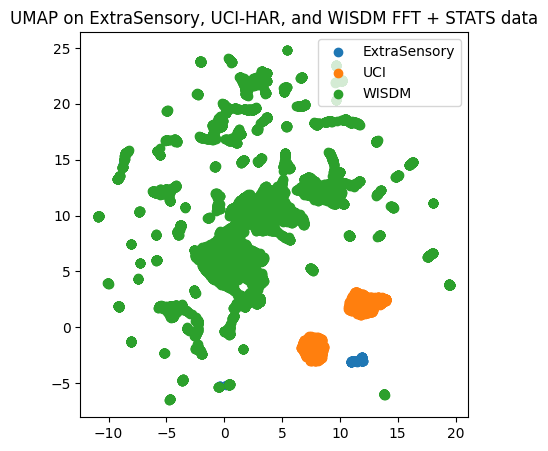

In [45]:
model = UMAP(n_components=2, random_state=42)
result = pd.DataFrame(model.fit_transform(train_universal_fft_stats[:][0]), columns=["x", "y"])
result["label"] = train_universal_fft_stats[:][1]
plot(result, title="UMAP on ExtraSensory, UCI-HAR, and WISDM FFT + STATS data", labels = labels)

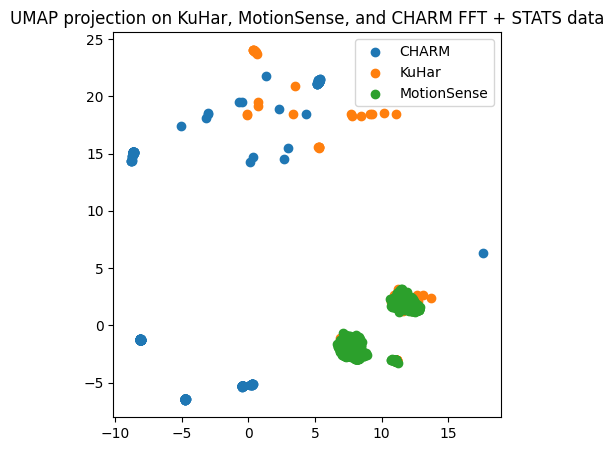

In [46]:
# model = UMAP(n_components=2)
result = pd.DataFrame(model.transform(test_fft_stats[:][0]), columns=["x", "y"])
result["label"] = test_fft_stats[:][1]
plot(result, title="UMAP projection on KuHar, MotionSense, and CHARM FFT + STATS data", labels = labels)

### T-SNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


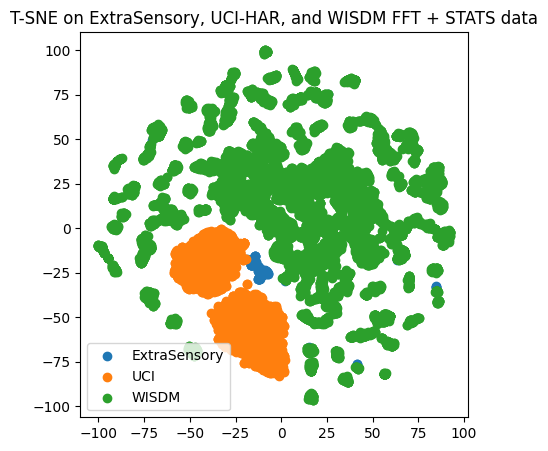

In [47]:
model = TSNE(n_components=2, random_state=42)
result = pd.DataFrame(model.fit_transform(train_universal_fft_stats[:][0]), columns=["x", "y"])
result["label"] = train_universal_fft_stats[:][1]
plot(result, title="T-SNE on ExtraSensory, UCI-HAR, and WISDM FFT + STATS data", labels=labels)